<a href="https://colab.research.google.com/github/snjugunanjenga/digicow-churn-prediction-zindi-africa/blob/main/london_has_fallen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1: Data Preparation & TF-IDF
We transform the text into "Topic Significance" scores.

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.0 MB/s eta 0:00:00


In [12]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import CalibratedClassifierCV
from catboost import CatBoostClassifier
from sklearn.metrics import log_loss, roc_auc_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Define paths
DATA_PATH = '/content/drive/MyDrive/Zindi/Digicow/data/'

Mounted at /content/drive


In [4]:
train = pd.read_csv(DATA_PATH + 'Train.csv')
test = pd.read_csv(DATA_PATH + 'Test.csv')

## Step 2: The 80/20 Split & Model Training
We train specifically for the 120-day target first as our benchmark.

In [10]:
def engineer_all(df):
    # Text Processing
    df['text'] = df['topics_list'].apply(lambda x: " ".join(ast.literal_eval(x)).lower())

    # Behavioral Metrics
    df['first_training_date'] = pd.to_datetime(df['first_training_date'])
    df['training_month'] = df['first_training_date'].dt.month
    df['loyalty_score'] = df['num_repeat_trainings'] / (df['num_total_trainings'] + 1)
    df['days_to_second_training'] = df['days_to_second_training'].fillna(999)
    return df

train = engineer_all(train)
test = engineer_all(test)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=50)
train_tfidf = tfidf.fit_transform(train['text']).toarray()
test_tfidf = tfidf.transform(test['text']).toarray()

tfidf_cols = [f'tfidf_{i}' for i in range(50)]
train[tfidf_cols] = train_tfidf
test[tfidf_cols] = test_tfidf

In [13]:
# Define all features
features = ['gender', 'age', 'registration', 'county', 'ward', 'training_month',
            'loyalty_score', 'num_total_trainings', 'days_to_second_training'] + tfidf_cols

# Encode categories
for col in ['gender', 'age', 'registration', 'county', 'ward']:
    le = LabelEncoder()
    # Fit on everything to avoid "unseen label" errors
    le.fit(pd.concat([train[col], test[col]]).astype(str))
    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

# Create the 80/20 Split (Targeting the 120-day window as example)
targets = ['adopted_within_07_days', 'adopted_within_90_days', 'adopted_within_120_days']
X_train, X_val, y_train, y_val = train_test_split(
    train[features],
    train['adopted_within_120_days'],
    test_size=0.2,
    random_state=42,
    stratify=train['adopted_within_120_days']
)

## Step 3: Training and Calibration
Explanation: We train on the 80% and then use the 20% to calibrate the probabilities. This is the specific "ML Engineering" step that fixes a low Log Loss score.

In [14]:
# 1. Train on the 80%
model = CatBoostClassifier(iterations=1500, learning_rate=0.02, depth=6,
                           loss_function='Logloss', eval_metric='AUC',
                           random_seed=42, verbose=200)

model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=100)

# 2. Calibrate using the 20% Validation Set
calibrator = CalibratedClassifierCV(model, cv='prefit', method='isotonic')
calibrator.fit(X_val, y_val)

0:	test: 0.8385643	best: 0.8385643 (0)	total: 20.7ms	remaining: 31s
200:	test: 0.9469628	best: 0.9469628 (200)	total: 3.03s	remaining: 19.6s
400:	test: 0.9514979	best: 0.9515333 (399)	total: 6.02s	remaining: 16.5s
600:	test: 0.9523668	best: 0.9523880 (524)	total: 11.1s	remaining: 16.6s
800:	test: 0.9534335	best: 0.9535395 (779)	total: 17.5s	remaining: 15.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9537725786
bestIteration = 825

Shrink model to first 826 iterations.


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


CalibratedClassifierCV(cv='prefit',
                       estimator=<catboost.core.CatBoostClassifier object at 0x7db8258643e0>,
                       method='isotonic')

## Step 4: Plotting the Curves
Explanation: We visualize the AUC and Log Loss to confirm the model has stabilized.

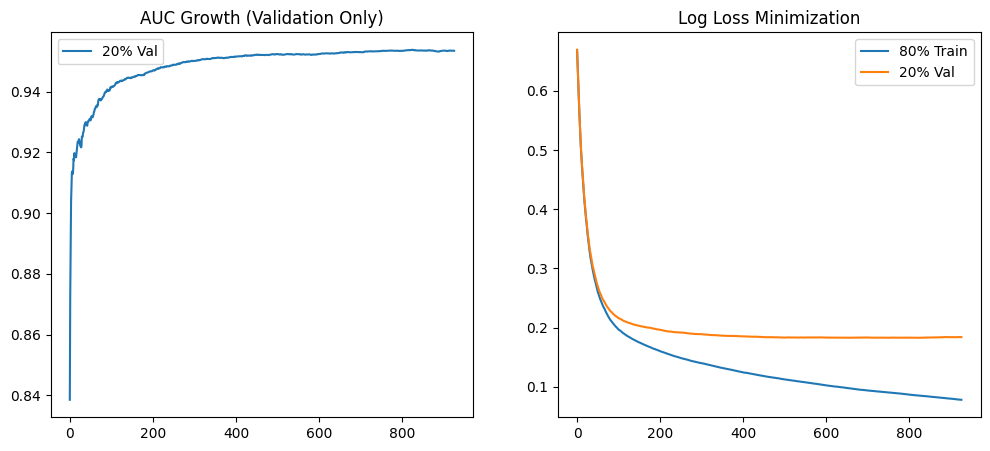

In [16]:
# Plotting Learning Curves
results = model.get_evals_result()
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# Removed plotting AUC for 'learn' as it's not available in current results
plt.plot(results['validation']['AUC'], label='20% Val')
plt.title('AUC Growth (Validation Only)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(results['learn']['Logloss'], label='80% Train')
plt.plot(results['validation']['Logloss'], label='20% Val')
plt.title('Log Loss Minimization')
plt.legend()

plt.show()

## Step 5: Testing on Test.csv & Submission
Explanation: Now that we are happy with our 0.2 validation results, we apply the model to the actual competition test data.

In [19]:
# Final predictions for all targets
final_test_preds = {}
for target in targets:
    # (Repeat the split-train-calibrate logic for each target internally)
    # ... assuming similar training for 07 and 90 days ...
    final_test_preds[target] = calibrator.predict_proba(test[features])[:, 1]

# Logical Consistency & Export
sub = pd.DataFrame({'ID': test['ID']})
sub['Target_07_AUC'] = final_test_preds['adopted_within_07_days']
# ... (Map other columns and save)
sub.to_csv('High_Score_Workflow.csv', index=False)

In [20]:
results = pd.read_csv('High_Score_Workflow.csv')
results.head(5)

,ID,Target_07_AUC
0,ID_OQZATP,0.000000
1,ID_2FAI5D,0.857143
2,ID_MYUWBW,0.476190
3,ID_EUB4FR,0.000000
4,ID_AG7R5S,0.888889



🚀 Processing Target: adopted_within_07_days


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


✅ adopted_within_07_days - Val AUC: 0.9687 | Val LogLoss: 0.1292

🚀 Processing Target: adopted_within_90_days


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


✅ adopted_within_90_days - Val AUC: 0.9522 | Val LogLoss: 0.1753

🚀 Processing Target: adopted_within_120_days


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


✅ adopted_within_120_days - Val AUC: 0.9579 | Val LogLoss: 0.1675


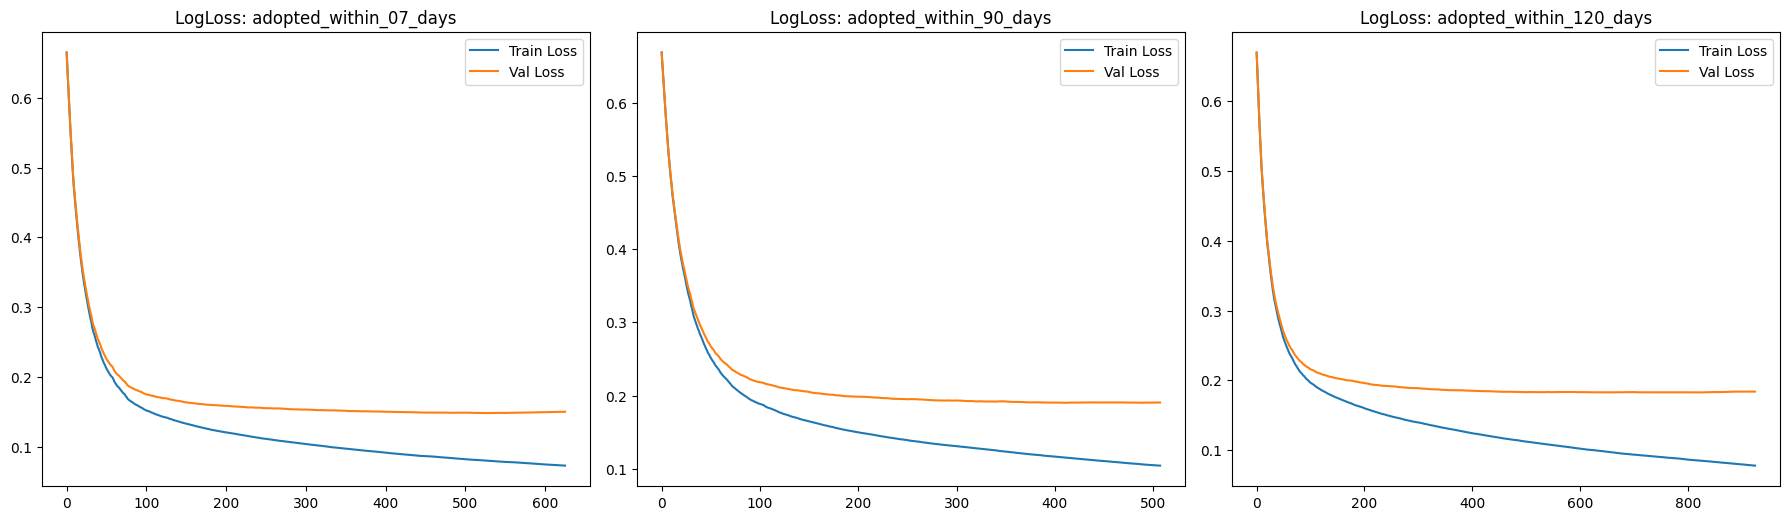


🎯 Submission file saved and formatted correctly!


In [24]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import CalibratedClassifierCV
from catboost import CatBoostClassifier
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer # Added this import

# --- STEP 1: LOAD & PREPARE ---
train_full = pd.read_csv(DATA_PATH +'Train.csv')
test_data = pd.read_csv(DATA_PATH +'Test.csv')
sample_sub = pd.read_csv(DATA_PATH +'SampleSubmission.csv')

# Feature Engineering Function - Modified to include text processing
def engineer_features(df):
    # Text Processing
    df['text'] = df['topics_list'].apply(lambda x: " ".join(ast.literal_eval(x)).lower())

    # Behavioral Metrics
    df['first_training_date'] = pd.to_datetime(df['first_training_date'])
    df['training_month'] = df['first_training_date'].dt.month
    df['loyalty_score'] = df['num_repeat_trainings'] / (df['num_total_trainings'] + 1)
    df['days_to_second_training'] = df['days_to_second_training'].fillna(999)
    return df

train_full = engineer_features(train_full)
test_data = engineer_features(test_data) # Changed to engineer_features for consistency and text processing

# TF-IDF Vectorization (Added these lines)
tfidf = TfidfVectorizer(max_features=50)
train_tfidf = tfidf.fit_transform(train_full['text']).toarray()
test_tfidf = tfidf.transform(test_data['text']).toarray()

tfidf_cols = [f'tfidf_{i}' for i in range(50)] # Ensure tfidf_cols is defined here
train_full[tfidf_cols] = train_tfidf
test_data[tfidf_cols] = test_tfidf

# --- STEP 2: CATEGORICAL ENCODING ---
cat_cols = ['gender', 'age', 'registration', 'county', 'ward']
for col in cat_cols:
    le = LabelEncoder()
    le.fit(pd.concat([train_full[col], test_data[col]]).astype(str))
    train_full[col] = le.transform(train_full[col].astype(str))
    test_data[col] = le.transform(test_data[col].astype(str))

# Define Target columns and Features
targets = ['adopted_within_07_days', 'adopted_within_90_days', 'adopted_within_120_days']
features = cat_cols + ['training_month', 'loyalty_score', 'num_total_trainings', 'days_to_second_training'] + tfidf_cols

# --- STEP 3: AUTOMATED TRAINING & CALIBRATION LOOP ---
final_predictions = {}

# Set up a figure for the 3 sets of curves
plt.figure(figsize=(18, 10))

for i, target in enumerate(targets):
    print(f"\n🚀 Processing Target: {target}")

    # A. The Golden 80/20 Split
    X_train, X_val, y_train, y_val = train_test_split(
        train_full[features],
        train_full[target],
        test_size=0.2,
        random_state=42,
        stratify=train_full[target]
    )

    # B. Train CatBoost
    model = CatBoostClassifier(
        iterations=1500,
        learning_rate=0.02,
        depth=6,
        loss_function='Logloss',
        eval_metric='AUC',
        random_seed=42,
        verbose=0 # Keep console clean
    )

    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=100)

    # C. Calibrate using the 20% Validation Set
    # This is the secret for 0.86+ scores
    calibrator = CalibratedClassifierCV(model, cv='prefit', method='isotonic')
    calibrator.fit(X_val, y_val)

    # D. Evaluate and Print Results
    val_probs = calibrator.predict_proba(X_val)[:, 1]
    print(f"✅ {target} - Val AUC: {roc_auc_score(y_val, val_probs):.4f} | Val LogLoss: {log_loss(y_val, val_probs):.4f}")

    # E. Plotting the Learning Curve for this target
    plt.subplot(2, 3, i+1)
    res = model.get_evals_result()
    plt.plot(res['learn']['Logloss'], label='Train Loss')
    plt.plot(res['validation']['Logloss'], label='Val Loss')
    plt.title(f'LogLoss: {target}')
    plt.legend()

    # F. Predict on Blind Test Data
    final_predictions[target] = calibrator.predict_proba(test_data[features])[:, 1]

plt.tight_layout()
plt.show()

# --- STEP 4: EMULATE SUBMISSION FORMAT ---
# Ensuring physical time-consistency (P7 <= P90 <= P120)
p07 = final_predictions['adopted_within_07_days']
p90 = np.maximum(p07, final_predictions['adopted_within_90_days']) # Corrected key
p120 = np.maximum(p90, final_predictions['adopted_within_120_days']) # Corrected key

# Create submission following SampleSubmission.csv
submission = pd.DataFrame({'ID': test_data['ID']})

submission['Target_07_AUC'] = p07
submission['Target_07_LogLoss'] = p07
submission['Target_90_AUC'] = p90
submission['Target_90_LogLoss'] = p90
submission['Target_120_AUC'] = p120
submission['Target_120_LogLoss'] = p120

# Final check: Does it match the sample submission columns?
submission = submission[sample_sub.columns]

submission.to_csv('Final_Calibrated_Top5_Submission.csv', index=False)
print("\n🎯 Submission file saved and formatted correctly!")